In [ ]:
cd ..

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import pickle, random, itertools, os
import numpy as np
import matplotlib.pyplot as plt

from pre_processing import Voc
from settings import *

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

## Loading data and batching

In [2]:
with open(save_dir + '/voc.pkl',  'rb') as f:
    voc   = pickle.load(f)
    
with open(save_dir + '/pairs.pkl','rb') as f:
    pairs = pickle.load(f)
    
with open("./data/loss_log.pkl", 'rb') as f:
    loss_log = pickle.load(f)

In [3]:
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(indexes_batch):
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(indexes_batch):
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(pair_batch):
    pair_batch.sort(key=lambda x: len(x[0]), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch)
    output, mask, max_target_len = outputVar(output_batch)
    return inp, lengths, output, mask, max_target_len

In [4]:
# Example for validation
small_batch_size = 6
pairs_list = [random.choice(pairs) for _ in range(small_batch_size)]
batches = batch2TrainData(pairs_list)
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:\n", input_variable)
print("lengths:", lengths)
print("target_variable:\n", target_variable)
print("mask:\n", mask)
print("max_target_len:", max_target_len)

input_variable:
 tensor([[   61, 11985,  2754,   457,    73,    73],
        [   39,     7,  2459,   233,   912,   340],
        [   14,     7,     7,   449,   102,     3],
        [ 3526,     7, 13669,     7,    75,    75],
        [   27,    73,     7,     2,     2,     2],
        [   12,   912,  1196,     0,     0,     0],
        [  996,   102,     2,     0,     0,     0],
        [  158,    75,     0,     0,     0,     0],
        [ 1500,     2,     0,     0,     0,     0],
        [  883,     0,     0,     0,     0,     0],
        [  594,     0,     0,     0,     0,     0],
        [   46,     0,     0,     0,     0,     0],
        [    7,     0,     0,     0,     0,     0],
        [    2,     0,     0,     0,     0,     0]])
lengths: tensor([14,  9,  7,  5,  5,  5])
target_variable:
 tensor([[   24, 13025,  1299,    31,    73,  8899],
        [  517,     7,    35,   233, 11738,     7],
        [   39,     2,   109,  6185,    75,     2],
        [   14,     0,    33,    48,  

## Modelo

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [6]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [7]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1,tie_weights=False):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)
        
        if tie_weights:
            self.out.weight = self.embedding.weight

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [8]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training

In [10]:
def plot_loss(d):
    x,y=[],[]
    for k,v in d.items():
            x.append(k)
            y.append(v)
    plt.plot(x,y)

In [11]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [12]:
def trainIters(voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, 
               encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, 
               clip, corpus_name, loadFilename, total_iter):

    # Load batches for each iteration
    #TODO: generator form to save memory of training_batches
    training_batches = [batch2TrainData([random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
#     print('Initializing ...')
    start_iteration = 0
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration']

    # Training loop
#     print("Training...")
    for iteration in range(1,n_iteration+1):
        training_batch = training_batches[iteration-1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            assert np.isnan(print_loss_avg) == False
            loss_dict[total_iter+iteration] = print_loss_avg
            print(f"Iteration: {iteration}; Percent complete: {iteration / n_iteration * 100:.1f}%; "
                  f"Average loss: {print_loss_avg:.4f}")
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, "checkpoints")
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': start_iteration+iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict(),
                "total_iter": total_iter+iteration,
                'loss': loss_dict #for plotting
            }, os.path.join(directory, f'{start_iteration+iteration}_checkpoint.tar'))

In [24]:
# Configure models
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500 #tamaño del embedding y del hidden, tienen que ser iguales para el output embedding
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 128

# Set checkpoint to load from; set to None if starting from scratch
train_from_zero = True
load_last_iter  = False
chkpt_dir = os.path.join(save_dir, "checkpoints")

if train_from_zero:
    loadFilename = None
    total_iter = 0
    loss_dict = {}
else:
    if load_last_iter: #load last save
        chkpt = os.listdir(chkpt_dir)[-1]
        loadFilename = os.path.join(chkpt_dir,chkpt)
    else:    
        checkpoint_iter = 20_000 #load especific iter
        loadFilename = os.path.join(chkpt_dir, f'{checkpoint_iter}_checkpoint.tar')

print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)

# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout,True)
print("Nº of params: ", count_parameters(encoder) + count_parameters(decoder))

# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))+
    encoder.load_state_dict(checkpoint['en'])
    decoder.load_state_dict(checkpoint['de'])
    embedding.load_state_dict(checkpoint['embedding'])
    voc.__dict__ = checkpoint['voc_dict']
    total_iter = checkpoint["total_iter"]
    loss_dict = checkpoint["loss"]
    
print('Models built and ready to go!')

Building encoder and decoder ...
Nº of params:  24794262
Models built and ready to go!


In [25]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1
learning_rate = 4e-5
decoder_learning_ratio = 5.0
n_iteration = 10_000
print_every = 1_000
save_every = 11_000
wd = 1e-5

In [26]:
# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate,weight_decay=wd)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio,weight_decay=wd)
if loadFilename:
    encoder_optimizer.load_state_dict(checkpoint['en_opt'])
    decoder_optimizer.load_state_dict(checkpoint['de_opt'])

Building optimizers ...


No. iterations: 0
Iteration: 1000; Percent complete: 10.0%; Average loss: 5.3760
Iteration: 2000; Percent complete: 20.0%; Average loss: 4.6423
Iteration: 3000; Percent complete: 30.0%; Average loss: 4.4530
Iteration: 4000; Percent complete: 40.0%; Average loss: 4.3211
Iteration: 5000; Percent complete: 50.0%; Average loss: 4.2220
Iteration: 6000; Percent complete: 60.0%; Average loss: 4.1383
Iteration: 7000; Percent complete: 70.0%; Average loss: 4.0568
Iteration: 8000; Percent complete: 80.0%; Average loss: 3.9938
Iteration: 9000; Percent complete: 90.0%; Average loss: 3.9340
Iteration: 10000; Percent complete: 100.0%; Average loss: 3.8714
CPU times: user 22min 4s, sys: 7min 5s, total: 29min 9s
Wall time: 29min 13s


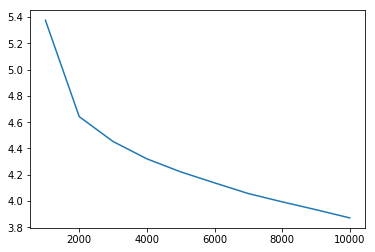

In [27]:
%%time
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()
# Run training iterations
for _ in range(1):
    print(f"No. iterations: {total_iter}")
    trainIters(voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
               embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
               print_every, save_every, clip, corpus_name, loadFilename,total_iter)
    total_iter+=n_iteration
    
    with open("./data/loss_log.pkl", 'wb') as f:
        loss_log[corpus_name] = loss_dict
        pickle.dump(loss_log, f)
    plot_loss(loss_dict)

In [28]:
loss_log['seq2seq'] = loss_log[corpus_name]
loss_log.pop(corpus_name)

{1000: 5.375969847213121,
 2000: 4.642332661978188,
 3000: 4.452988441398011,
 4000: 4.321142806216961,
 5000: 4.22195488286207,
 6000: 4.13832092745432,
 7000: 4.056781418907795,
 8000: 3.9938076537267864,
 9000: 3.9340317300650796,
 10000: 3.871379757478697}

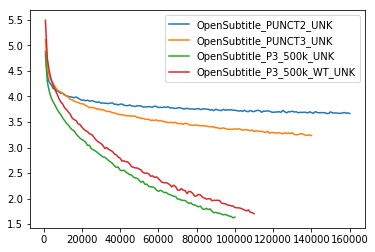

In [5]:
#tres metodos de tratar la puntuacion, entrenado por 14 "epochs" con 4e4 y 2 con 4e5
l = list(loss_log.keys())
for k,v in loss_log.items():
    plot_loss(v)
    plt.gca().legend(l)

In [ ]:
#next
#test y subir modelo?
#guardar tiempo 10epochs y num params
#grafico de loss escalado a tiempo, y scatter plt de loss at 10 y num of params
#implement outputs layers

In [ ]:
#train with simple punct
#reduce data to see how affect to training. smaller data faster training(worse generaliaztion but useful to do test runs)

## Eval 

In [18]:
import re
from pre_processing import process_punct, indexesFromSentence

In [19]:
def custom_capitalize(s):
    for i, c in enumerate(s):
        if c.isalpha():
            break
    return s[:i] + s[i:].capitalize()

In [20]:
def reformatString(l):
    s = l.strip().lower()
#     s = re.sub(r"<guion_inic>",r"", s)
    s = re.sub(r"\s+([.!?])", r"\1", s)
    s = re.sub(r"([¡¿])\s+", r"\1", s)
    s = re.sub(r"\s+", r" ", s)
    return custom_capitalize(s).strip()

In [21]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [22]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    sentence = sentence.split()
    indexes_batch = [indexesFromSentence(sentence, voc)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
#             input_sentence = "-"+input_sentence #para que siga el formato de guiones de una conversacion
            input_sentence = process_punct(input_sentence.encode())
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            raw_ans = ' '.join(output_words)
            ans = reformatString(raw_ans)
            print('Bot:',ans)

        except KeyError:
            print("Error: Encountered unknown word.")

In [28]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> ¿cómo estás?
Bot: No quiero hacer una prueba. tu tu... tu
> ¿Cómo te llamas?
Bot: Eres mejor que aquí y si lo haces. tu tu tu.
> qué te pasa
Bot: Qué buena
> vaya mierda
Bot: Qué te parece tanto? muy muy
> mal
Bot: Te amo te amo te amo.
> vas mal
Bot: Te lo juro....
> no me lo jures
Bot: No
> vas a hablar bien
Bot: Decir muchacho muchacho
> repites palabras
Bot: ¿Te acuerdas? mi una
> a
Bot: Al rey conmigo conmigo le le perro perro
> a
Bot: Al rey conmigo conmigo le le perro perro
> s
Bot: Que que que que que que.
> d
Bot: Me gustaría saber una cosa.
> f
Bot: Es una buena idea..
> g
Bot: Al menos de 2 días no sé lo que le dije en no decir tren
> h
Bot: ¡Qué horror! la la en la la
> z
Bot: ¿Qué?
> x
Bot: ¿Qué hace una una hombre hombre hombre hombre hombre
> c
Bot: De acuerdo de de haber....
> v
Bot: Bailemos
> b
Bot: En la misma guerra una una una guerra
> n
Bot: No podemos seguir así. sin
> m
Bot: ¡Es un traidor! jamás
> t
Bot: Buenas noches luna todos todos casa casa


KeyboardInterrupt: 